# Boilerplate and Data Organization

In [27]:
#To make plots look sharper
%config InlineBackend.figure_format = 'retina'

In [28]:
#Boilerplate and Imports
import os
import nibabel
import nilearn
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
import nilearn.plotting as nplt
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import afidutils

exclude_afids = ['CULx','PGx','GENUx', 'SPLEx', 'ALTHx', 'SAMTHx', 'IAMTHx', 'IGOx','VOHx','OSFx',
                 'CULy','PGy','GENUy', 'SPLEy', 'ALTHy', 'SAMTHy', 'IAMTHy', 'IGOy','VOHy','OSFy',
                 'CULz','PGz','GENUz', 'SPLEz', 'ALTHz', 'SAMTHz', 'IAMTHz', 'IGOz','VOHz','OSFz'
                 ]

# Train Data Subject IDs
train_subids = pd.read_csv("/Users/alaataha/Documents/GitHub/afids-pred/data/coordinate/train_data.csv")
# Test Data Subject IDs - only used for exclusion
test_subids = pd.read_csv("/Users/alaataha/Documents/GitHub/afids-pred/data/coordinate/test_data.csv")

In [ ]:
# Load coordinate data (AFIDs) for preliminary analysis
# Looks for all files matching the pattern (i.e., MCP-aligned fiducials)
afid_fcsv = sorted(glob(f'/Users/alaataha/Documents/GitHub/afids-pred/data/coordinate/AFIDs/*/afids_mcp/*/*/*MCP*.fcsv'))
print(f'# of subjects: {len(afid_fcsv)}')  # Prints how many subject files were found

# Convert FCSV files into pandas DataFrames and associate them with datasets
dfs = []         # List to store individual AFID DataFrames
dataset = []     # List to store corresponding dataset names
for afid_file in afid_fcsv:
    dfs.append(afidutils.fcsvtodf(afid_file)[0])  # Convert the .fcsv file into a DataFrame
    dataset.append(afidutils.extract_sub_metadata(afid_file)[2])  # Extract dataset name from file path

# Combine all subject DataFrames into one master DataFrame
df_afids = pd.concat(dfs, axis=0)

# Set small float values (close to zero) to actual zero for cleaner data
df_afids = df_afids.map(afidutils.make_zero)  # Typically sets values between -0.01 and 0.01 to 0

# Save the raw AFID data for reference or future analysis
df_afids.to_csv('/Users/alaataha/Documents/GitHub/afids-pred/data/coordinate/AFIDs/df_afids_mcp_raw.csv')

# Remove extreme outliers (e.g., anything more than 7 SD away from the mean)
df_afids_mcp = afidutils.remove_outliers(df_afids, df_afids.columns, threshold=7)

# Create a mirrored version of the dataset across the x-axis
# This leverages the anatomical symmetry and assumes data is already AC-PC aligned
df_afids_mcp_l = df_afids_mcp.copy()
for column in df_afids_mcp_l.columns:
    if 'x' in column:  # Only mirror the x-coordinates (left/right axis)
        df_afids_mcp_l[column] *= -1

# Drop left-sided AFID coordinates from the original data
# Drop right-sided AFID coordinates from the mirrored data
# Midline points are retained with their sign intact (could contain meaningful asymmetry info)
df_afids_mcp = df_afids_mcp.drop(afidutils.left_afids, axis=1)
df_afids_mcp_l = df_afids_mcp_l.drop(afidutils.right_afids, axis=1)

# Rename columns so both DataFrames have matching labels (shared structure for merging)
df_afids_mcp.columns = afidutils.combined_lables
df_afids_mcp_l.columns = afidutils.combined_lables

# Combine the mirrored and non-mirrored data into one dataset (doubles the sample size)
combined = [df_afids_mcp, df_afids_mcp_l]
concatenated_df = pd.concat(combined)

# Filter data to only include relevant AFIDs that (1) feature sub-mm localization error and (2) circumscribe midbrain areas
concatenated_df = concatenated_df.drop(exclude_afids, axis= 1)

# Drop the testing dataset data to prevent leakage during feature exploration and PCA
concatenated_df = concatenated_df.drop(index=test_subids['subjid'].to_list())

# Print final dataset dimensions
print(f"# of examples after outlier removal: {concatenated_df.shape[0]}")
print(f"features: {concatenated_df.columns}")
print(f"# of features: {concatenated_df.shape[1]}")


# of subjects: 202
# of examples after outlier removal: 360
features: Index(['ACx', 'PCx', 'ICSx', 'PMJx', 'SIPFx', 'SLMSx', 'ILMSx', 'IMSx', 'MBx',
       'LVACx', 'LVPCx', 'ACy', 'PCy', 'ICSy', 'PMJy', 'SIPFy', 'SLMSy',
       'ILMSy', 'IMSy', 'MBy', 'LVACy', 'LVPCy', 'ACz', 'PCz', 'ICSz', 'PMJz',
       'SIPFz', 'SLMSz', 'ILMSz', 'IMSz', 'MBz', 'LVACz', 'LVPCz'],
      dtype='object')
# of features: 33


# Prelim Analysis and PCA

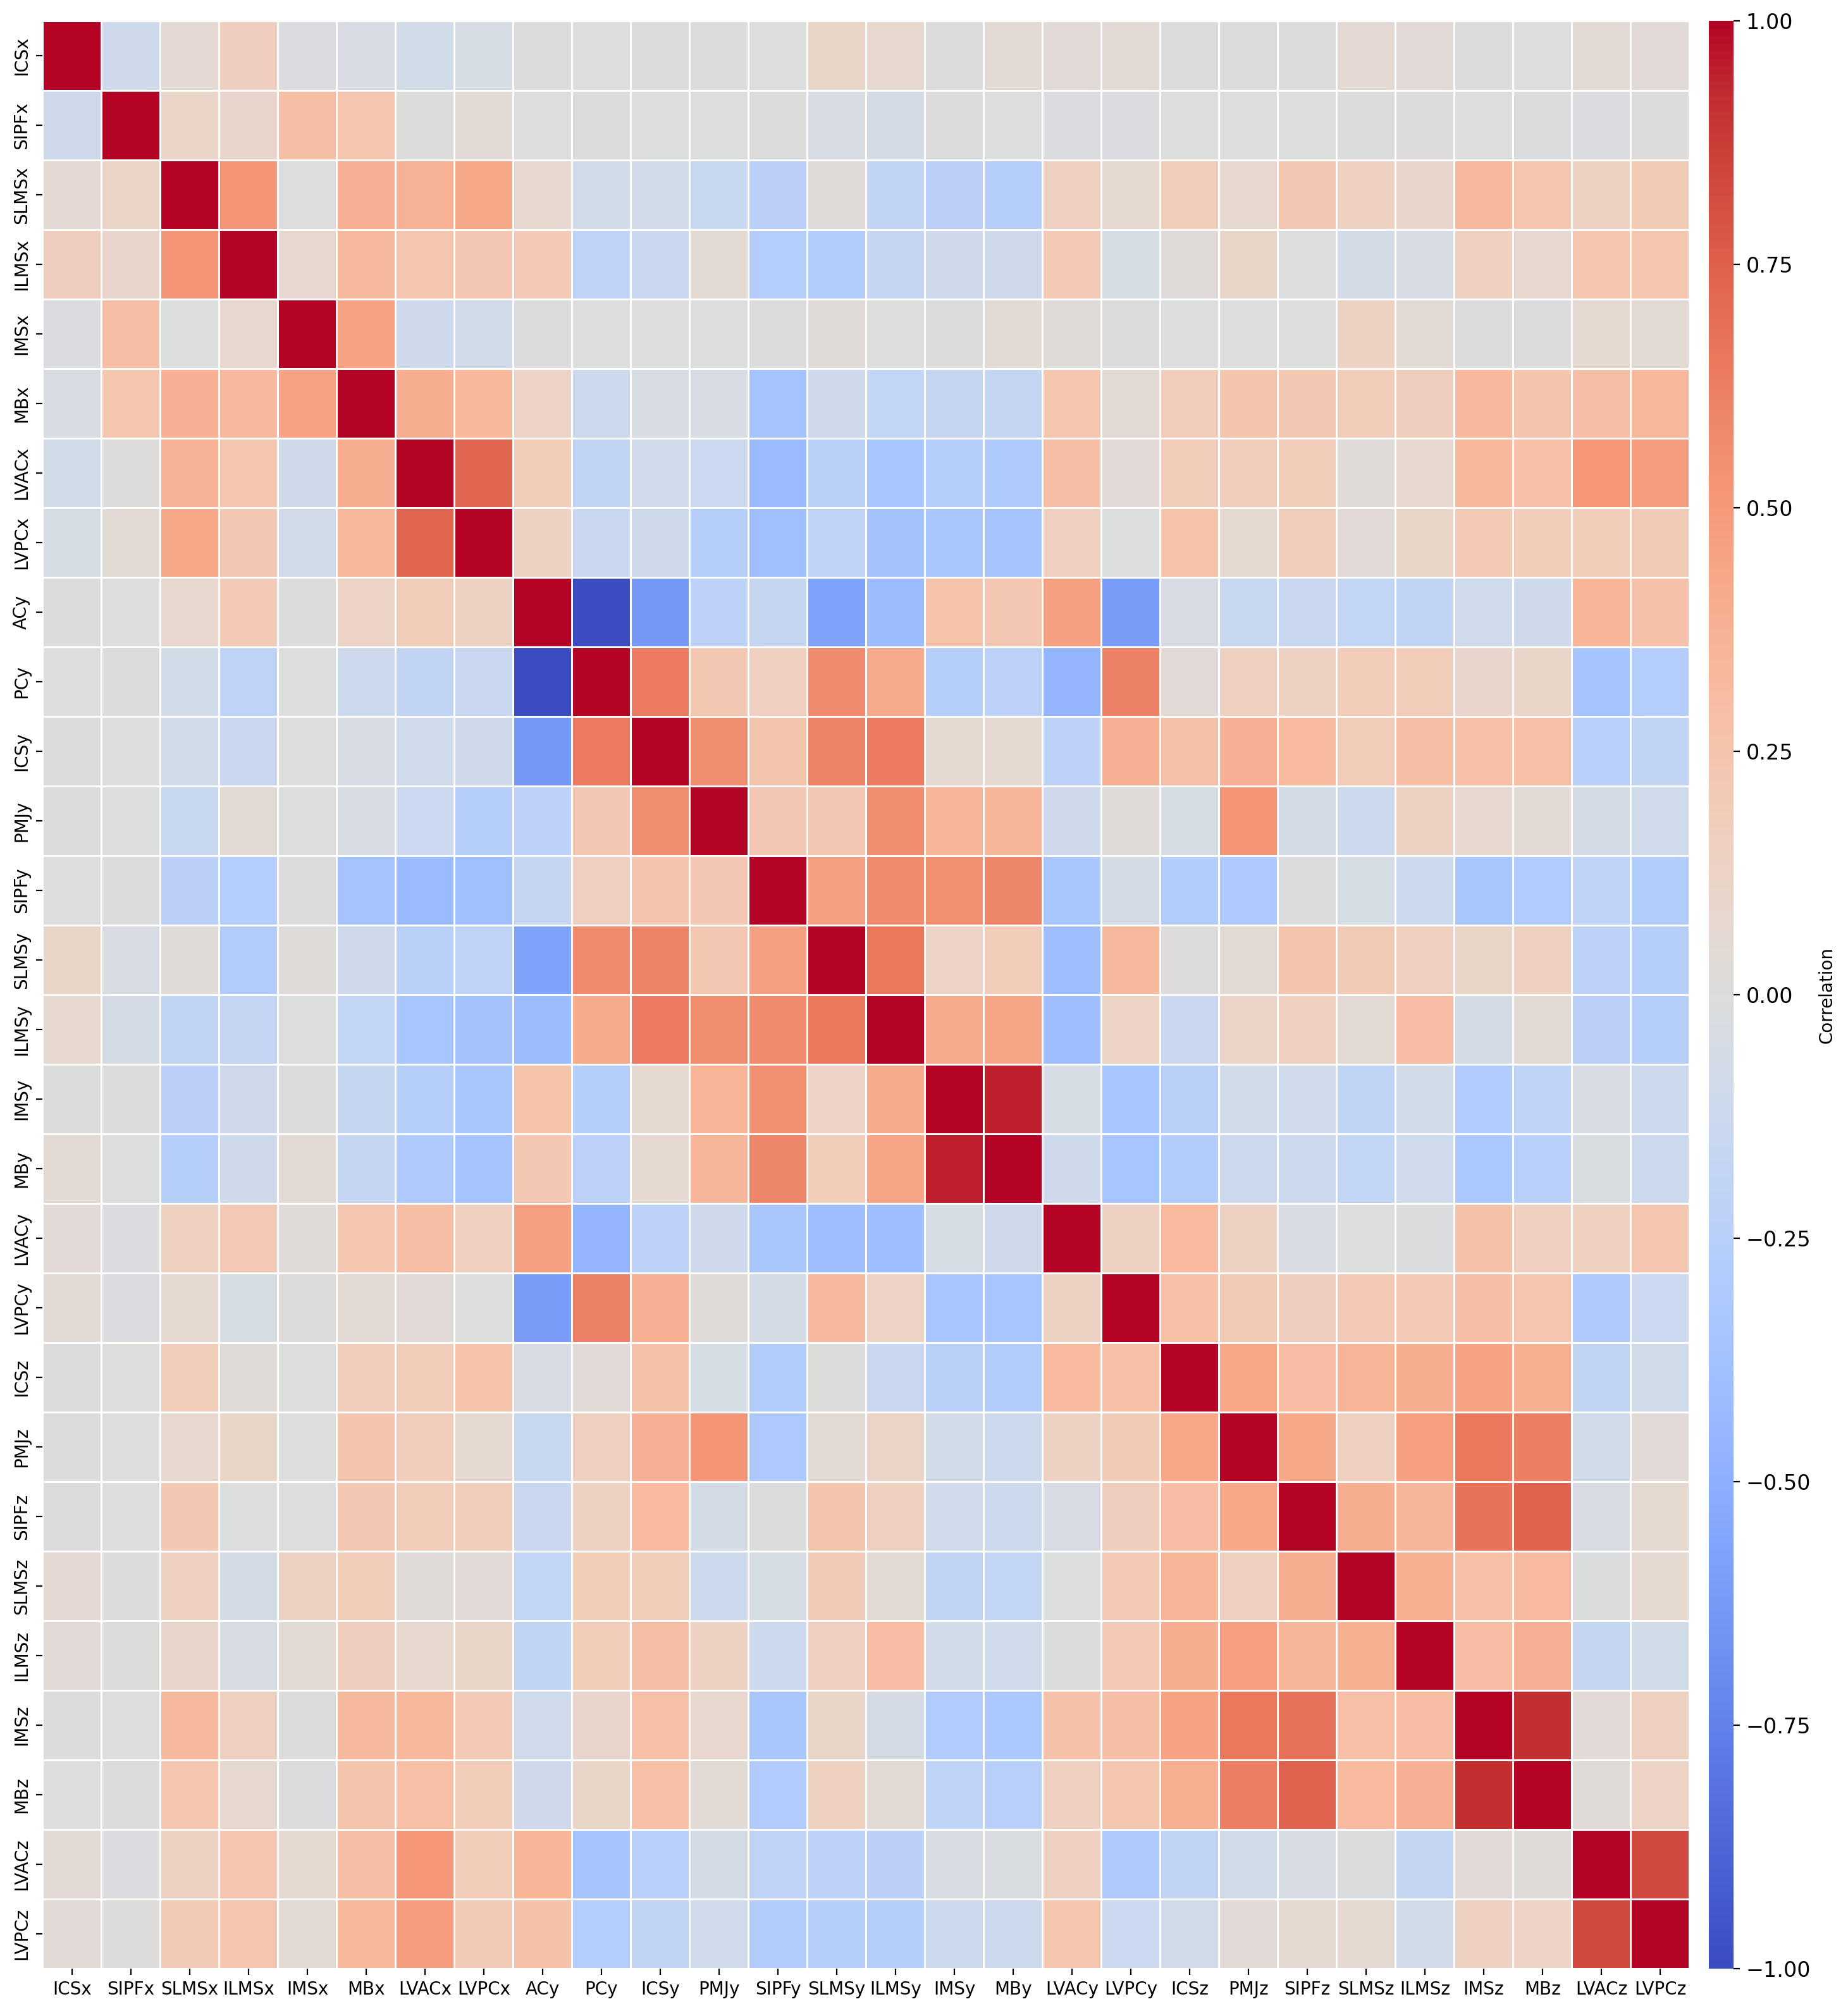

In [33]:
# create a correlation matrix using pandas
corr_df = concatenated_df.loc[:, (concatenated_df != 0).any(axis=0)] #removes coordinates that are zeros across the board (i.e., x_1,  x_2, x_midpoint and z_1 and z_2)

corr_matrix = corr_df.corr()
# plot the correlation matrix using matplotlib (prelimnary analysis to reveal relationships between AFID features across a wide range of participants)
fig, ax = plt.subplots(figsize=(20, 20))
heatmap = sns.heatmap(corr_matrix, cmap='coolwarm', annot=False,linewidths=.5, ax=ax, cbar_kws={'label': 'Correlation','aspect': 80,'pad': 0.01})
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
plt.show()
# Save the figure as a transparent PNG
fig.savefig(f'/Users/alaataha/Documents/GitHub/afids-pred/figures/correlation_matrix.png', dpi=300, bbox_inches='tight', transparent=True)

In [34]:
std_scaleall = StandardScaler()

scaled_dataall = std_scaleall.fit_transform(concatenated_df)

pcaall= PCA()

dim_reduced_dataall = pcaall.fit_transform(scaled_dataall)

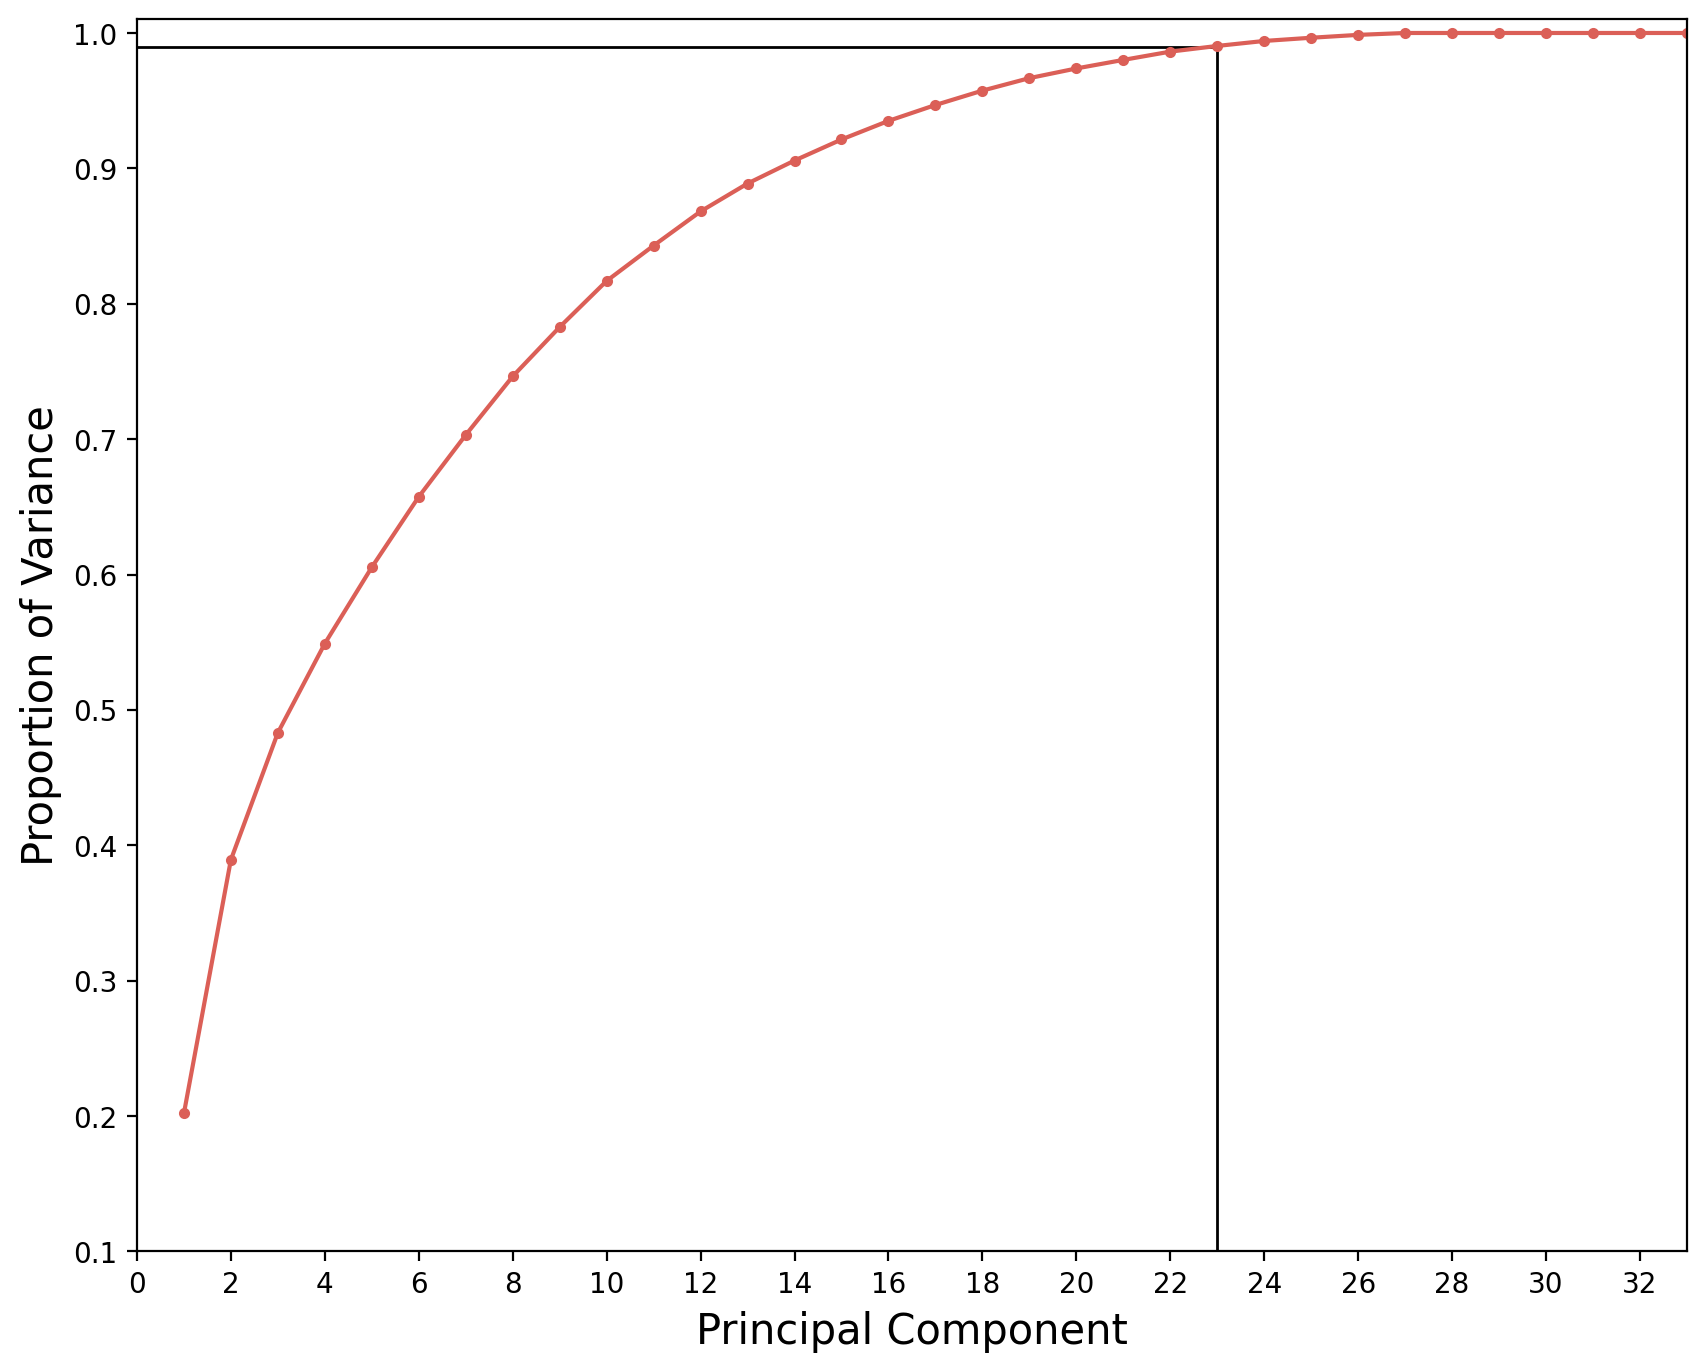

In [36]:
# Set a custom color palette and line styles
colors = sns.color_palette("hls", 8)

line_styles = ['-', '--','-.']
# Get the eigenvalues and calculate the proportion of variance explained
prop_varall = pcaall.explained_variance_ratio_


# Get the cumulative proportion of variance explained
cumulative_prop_all = np.cumsum(prop_varall)


# Create a figure and axes object
fig, ax = plt.subplots(figsize=(10, 8))


# Define the intersection point

y = 0.99 #desirred captured variance
x = np.abs(cumulative_prop_all - y).argmin() + 1 

# Compute the coordinates of the intersection point
xp = x #used later to index for heatmaps!
yp = y

plt.plot([x, xp], [0, yp], color='black', linewidth=1,linestyle=line_styles[0])
plt.plot([0, xp], [y, yp], color='black', linewidth=1,linestyle=line_styles[0])


# Plot the scree plot
ax.plot(np.arange(1, len(prop_varall)+1), cumulative_prop_all, linestyle=line_styles[0], marker='o', markersize=3, color=colors[0])


# Customize the plot
ax.set_xlabel('Principal Component', fontsize=15)
ax.set_ylabel('Proportion of Variance', fontsize=15)
#ax.legend(fontsize=12)

x_ticks = np.arange(0, concatenated_df.shape[1], 2)


# Set the x-tick locations
ax.set_xticks(x_ticks)

y_ticks = np.arange(0, 1.1, 0.1)

# Set the x-tick locations
ax.set_yticks(y_ticks)
plt.xlim(0, concatenated_df.shape[1])
plt.ylim(0.1, 1.01)
#ax.legend(loc='lower right')

# Save the figure as a PNG file
fig.savefig(f'/Users/alaataha/Documents/GitHub/afids-pred/figures/scree_plot.png', dpi=300, bbox_inches='tight',transparent=True)

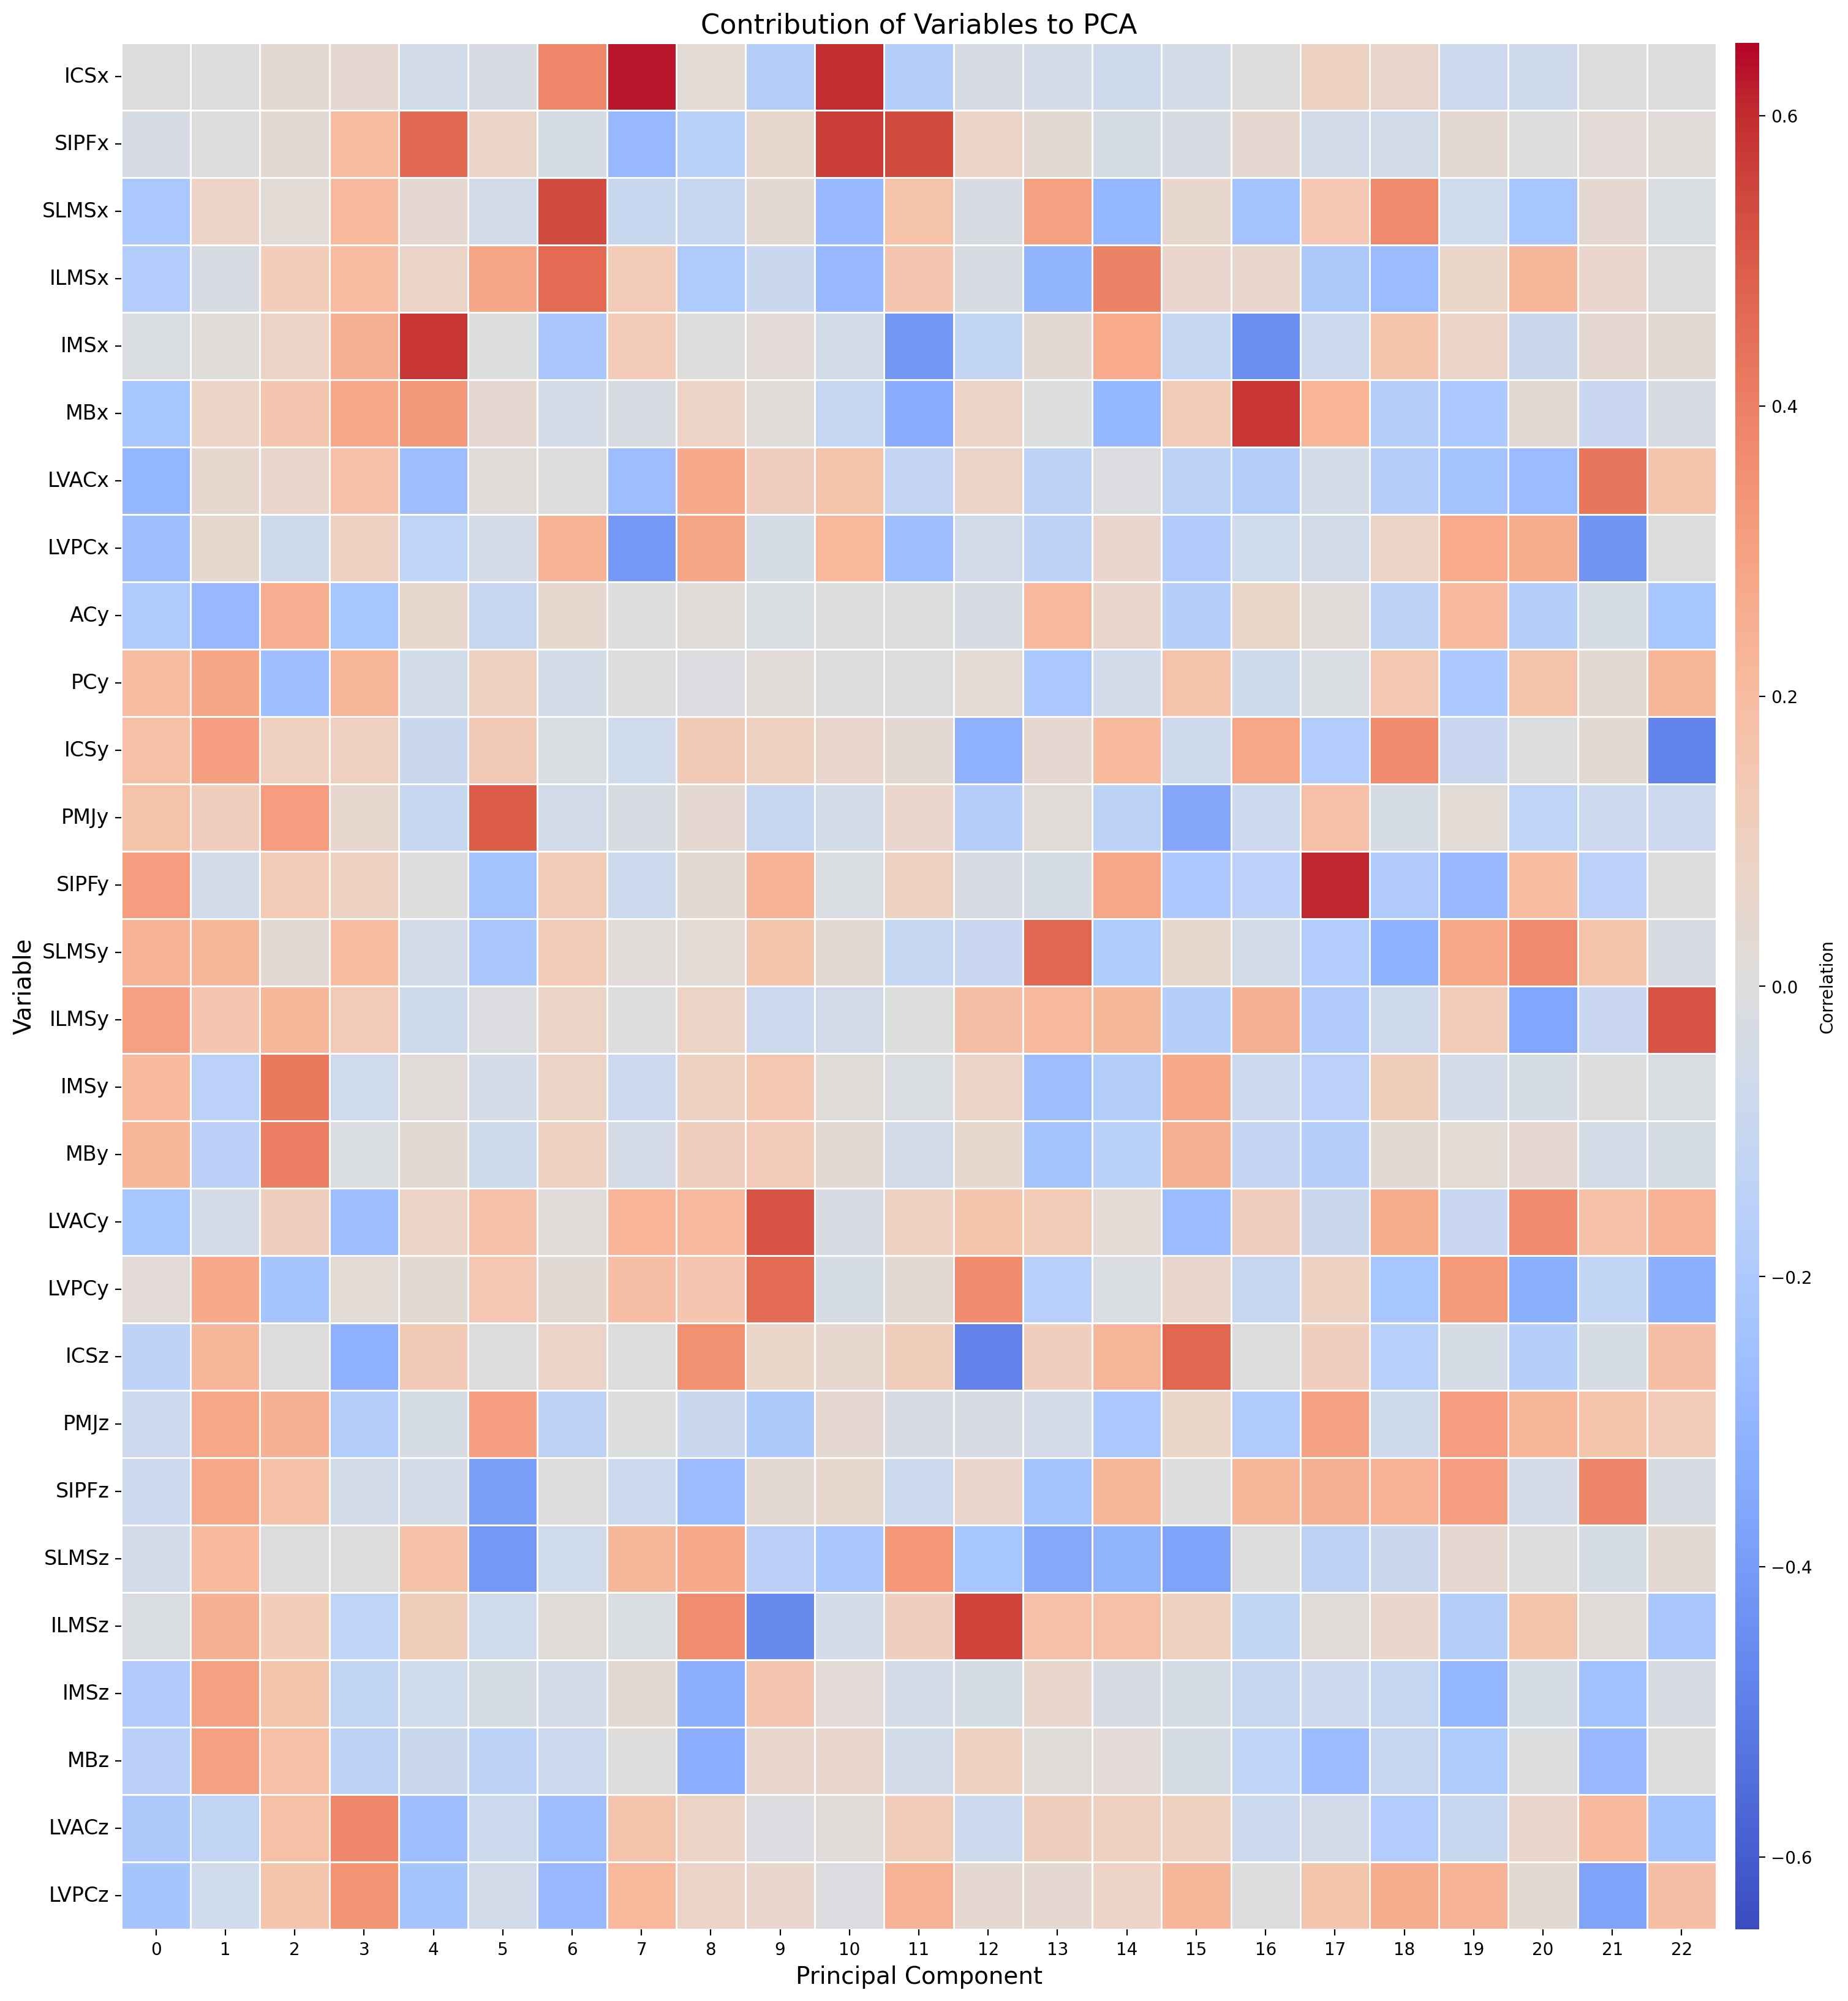

In [37]:
# Get the loadings matrix
loadingsall_df = pd.DataFrame(pcaall.components_[:xp,:])
loadingsall_df.columns= concatenated_df.columns
pca_contributions_df = loadingsall_df.drop(['ACx','PCx','PMJx','ACz','PCz'],axis =1)
pca_contributions_df = pca_contributions_df.T

# Compute global min and max for normalization
vmin = np.min(pca_contributions_df)
vmax = np.max(pca_contributions_df)
norm = TwoSlopeNorm(vmin=-0.65, vcenter=0, vmax=0.65)

# Set the figure size
plt.figure(figsize=(20, 20))

# Create heatmap with normalized colormap (0.0 will be white)
heatmap = sns.heatmap(pca_contributions_df,
                      cmap='coolwarm',
                      norm=norm,
                      annot=False,
                      linewidths=.5, 
                      cbar_kws={'label': 'Correlation','aspect': 80,'pad': 0.01})

# Set the title and labels
plt.title('Contribution of Variables to PCA', fontsize=16)
plt.ylabel('Variable', fontsize=14)
plt.xlabel('Principal Component', fontsize=14)

# Rotate y-axis labels and adjust font size
plt.yticks(rotation=0, fontsize=12)

# Save the plot
plt.savefig('/Users/alaataha/Documents/GitHub/afids-pred/figures/PCA_contributions.png', dpi=300, bbox_inches='tight', transparent=True)

# Show the plot
plt.show()

In [38]:
weightings = loadingsall_df

cols_to_modify = (weightings.select_dtypes(include='number') > -0.0001).all() & (weightings.select_dtypes(include='number') < 0.0001).all()
weightings.loc[:, cols_to_modify] = weightings.loc[:, cols_to_modify].map(afidutils.make_zero)

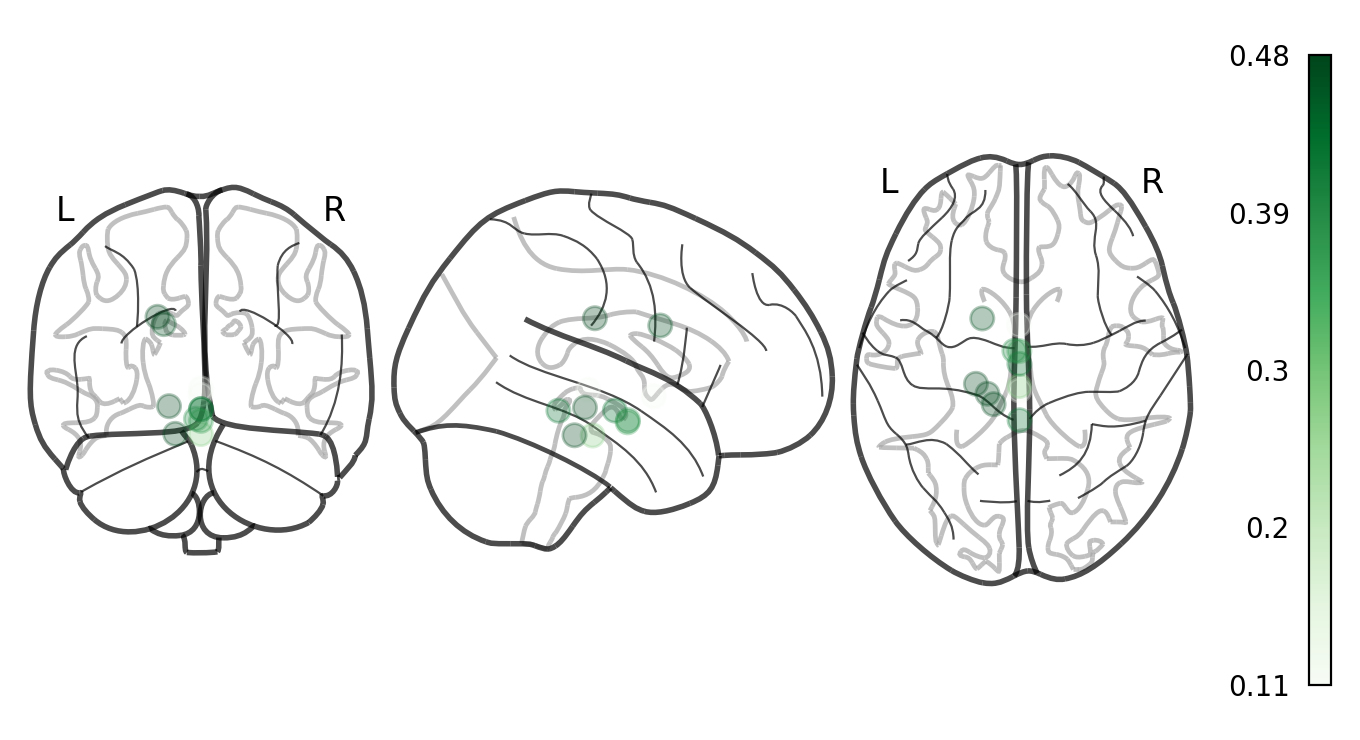

In [ ]:
abs_weights = abs(weightings).to_numpy()
contributions = []
ranges = abs_weights.shape[1]//3
for i in range(0,ranges):
  contributions.append((abs_weights[:,i]+abs_weights[:,i+ranges]+abs_weights[:,i+(ranges*2)]).mean())

# Plot the markers on the MNI space
coords_file_path = '/Users/alaataha/Documents/GitHub/afids-pred/resources/MNI152NLin2009cAsym/sub-MNI152NLin2009cAsym_res-01_desc-groundtruth_afids.fcsv'

# Load MNI coordinates
coords_df = pd.read_csv(coords_file_path,header = 2)

# Extract the coordinates as a NumPy array
coords = coords_df[['x', 'y', 'z']]
remove_list = [5, 7, 11, 14, 16, 9, 13, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
coords = coords.drop(index=remove_list, axis = 1)
coords = coords.reset_index(drop=True)

#overlay PCA contributions across all pcs
nplt.plot_markers(node_values = contributions, node_cmap='Greens', node_coords=coords, alpha=0.3, figure=None, axes=None, title=None, annotate=True, black_bg=False, node_kwargs=None, colorbar=True,node_size=70)
plt.savefig('/Users/alaataha/Documents/GitHub/afids-pred/figures/pc_cont_afids_allpcs.png', dpi=300, bbox_inches='tight', pad_inches=0.1, transparent=True)

# planes= ['xz', 'yx', 'yz', 'l', 'r', 'lr', 'lzr', 'lyr', 'lzry', 'lyrz']
# for orientation in planes:
#   nplt.plot_markers(node_values = contributions, node_cmap='coolwarm', node_coords=coords, alpha=0.5, figure=None, axes=None, title=None, annotate=True, black_bg=False, node_kwargs=None, colorbar=True,display_mode = orientation, node_size=80)
#   plt.savefig(f'pc_cont_afids_allpcs{orientation}.png', dpi=300, bbox_inches='tight', pad_inches=0.1, transparent=True)

In [ ]:
# Load coordinate data (STN) for preliminary analysis
# Looks for all files matching the pattern (i.e., MCP-aligned fiducials)
stn_fcsv = sorted(glob(f'/Users/alaataha/Documents/GitHub/afids-pred/data/coordinate/STN/*/stn_mcp/*/*/*MCP*.fcsv'))
print(f'# of subjects: {len(stn_fcsv)}')  # Prints how many subject files were found

# Convert FCSV files into pandas DataFrames and associate them with datasets
dfs_stn = []         # List to store individual AFID DataFrames
for stn_file in stn_fcsv:
    dfs_stn.append(afidutils.fcsvtodf(stn_file)[0])  # Convert the .fcsv file into a DataFrame

# Combine all subject DataFrames into one master DataFrame
df_stn = pd.concat(dfs_stn, axis=0)

stn_labels = ['RSTNx', 'LSTNx', 'RSTNy','LSTNy','RSTNz','LSTNz']
df_stn.columns  = stn_labels

# Save the raw AFID data for reference or future analysis
df_stn.to_csv('/Users/alaataha/Documents/GitHub/afids-pred/data/coordinate/STN/df_stn_mcp_raw.csv')

df_stn['LSTNx'] = df_stn['LSTNx']*-1

df_stn_r = df_stn[['RSTNx','RSTNy','RSTNz']]
df_stn_l = df_stn[['LSTNx','LSTNy','LSTNz']]

df_stn_r.columns  = ['STNx','STNy','STNz']
df_stn_l.columns  = ['STNx','STNy','STNz']


STN_target = pd.concat([df_stn_r , df_stn_l],axis=0)

subject_list = df_stn.index

df_sub_afids = []
for sub in subject_list: 
    file_path = sorted(glob(f"/Users/alaataha/Documents/GitHub/afids-pred/data/coordinate/AFIDs/*/afids_mcp/{sub}/anat/{sub}*.fcsv"))[0]
    sub_afids_fcsv = afidutils.fcsvtodf(file_path)[0]
    df_sub_afids.append(sub_afids_fcsv)

df_subs_afids = pd.concat(df_sub_afids, axis=0)

# Create a mirrored version of the dataset across the x-axis
# This leverages the anatomical symmetry and assumes data is already AC-PC aligned
df_subs_afids_l = df_subs_afids.copy()
for column in df_subs_afids_l.columns:
    if 'x' in column:  # Only mirror the x-coordinates (left/right axis)
        df_subs_afids_l[column] *= -1

# Drop left-sided AFID coordinates from the original data
# Drop right-sided AFID coordinates from the mirrored data
# Midline points are retained with their sign intact (could contain meaningful asymmetry info)
df_subs_afids = df_subs_afids.drop(afidutils.left_afids, axis=1)
df_subs_afids_l = df_subs_afids_l.drop(afidutils.right_afids, axis=1)

# Rename columns so both DataFrames have matching labels (shared structure for merging)
df_subs_afids.columns = afidutils.combined_lables
df_subs_afids_l.columns = afidutils.combined_lables

# Combine the mirrored and non-mirrored data into one dataset (doubles the sample size)
combined_subs_2 = [df_subs_afids, df_subs_afids_l]
concatenated_df_2 = pd.concat(combined_subs_2,axis=0)

# Filter data to only include relevant AFIDs that (1) feature sub-mm localization error and (2) circumscribe midbrain areas
concatenated_df_2 = concatenated_df_2.drop(exclude_afids, axis= 1)

concatenated_df_2 = concatenated_df_2.drop(index=test_subids['subjid'].to_list())
STN_target = STN_target.drop(index=test_subids['subjid'].to_list())

# of subjects: 70


/Users/alaataha/.pyenv/versions/3.11.10/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning:

invalid value encountered in divide

/Users/alaataha/.pyenv/versions/3.11.10/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning:

invalid value encountered in divide



Correlation with Target Variables:
           STNx      STNy      STNz
ACx         NaN       NaN       NaN
PCx         NaN       NaN       NaN
ICSx  -0.081073  0.094787  0.021028
PMJx        NaN       NaN       NaN
SIPFx   0.23189  0.006217  0.037721
SLMSx   0.53817 -0.236589 -0.390678
ILMSx  0.203048  0.027644 -0.051671
IMSx   0.141924  0.081266  0.039789
MBx     0.30966  0.194353 -0.171182
LVACx  0.449893 -0.127966 -0.292271
LVPCx  0.429235 -0.086069  -0.27638
ACy   -0.163993  0.221538 -0.032113
PCy    0.163993 -0.221538  0.032113
ICSy  -0.061026  0.074973  0.012046
PMJy  -0.171028  0.169161  0.223233
SIPFy -0.385873  0.240358   0.38205
SLMSy  -0.00495  0.281889   0.09715
ILMSy -0.089688  0.183325  0.248504
IMSy  -0.332701  0.274792   0.37989
MBy   -0.304789  0.338761  0.391499
LVACy -0.203368  0.266847  0.085409
LVPCy  0.077568  -0.11066  0.065342
ACz         NaN       NaN       NaN
PCz         NaN       NaN       NaN
ICSz  -0.101219   0.08369  0.228451
PMJz  -0.062574  0.088796 -0.

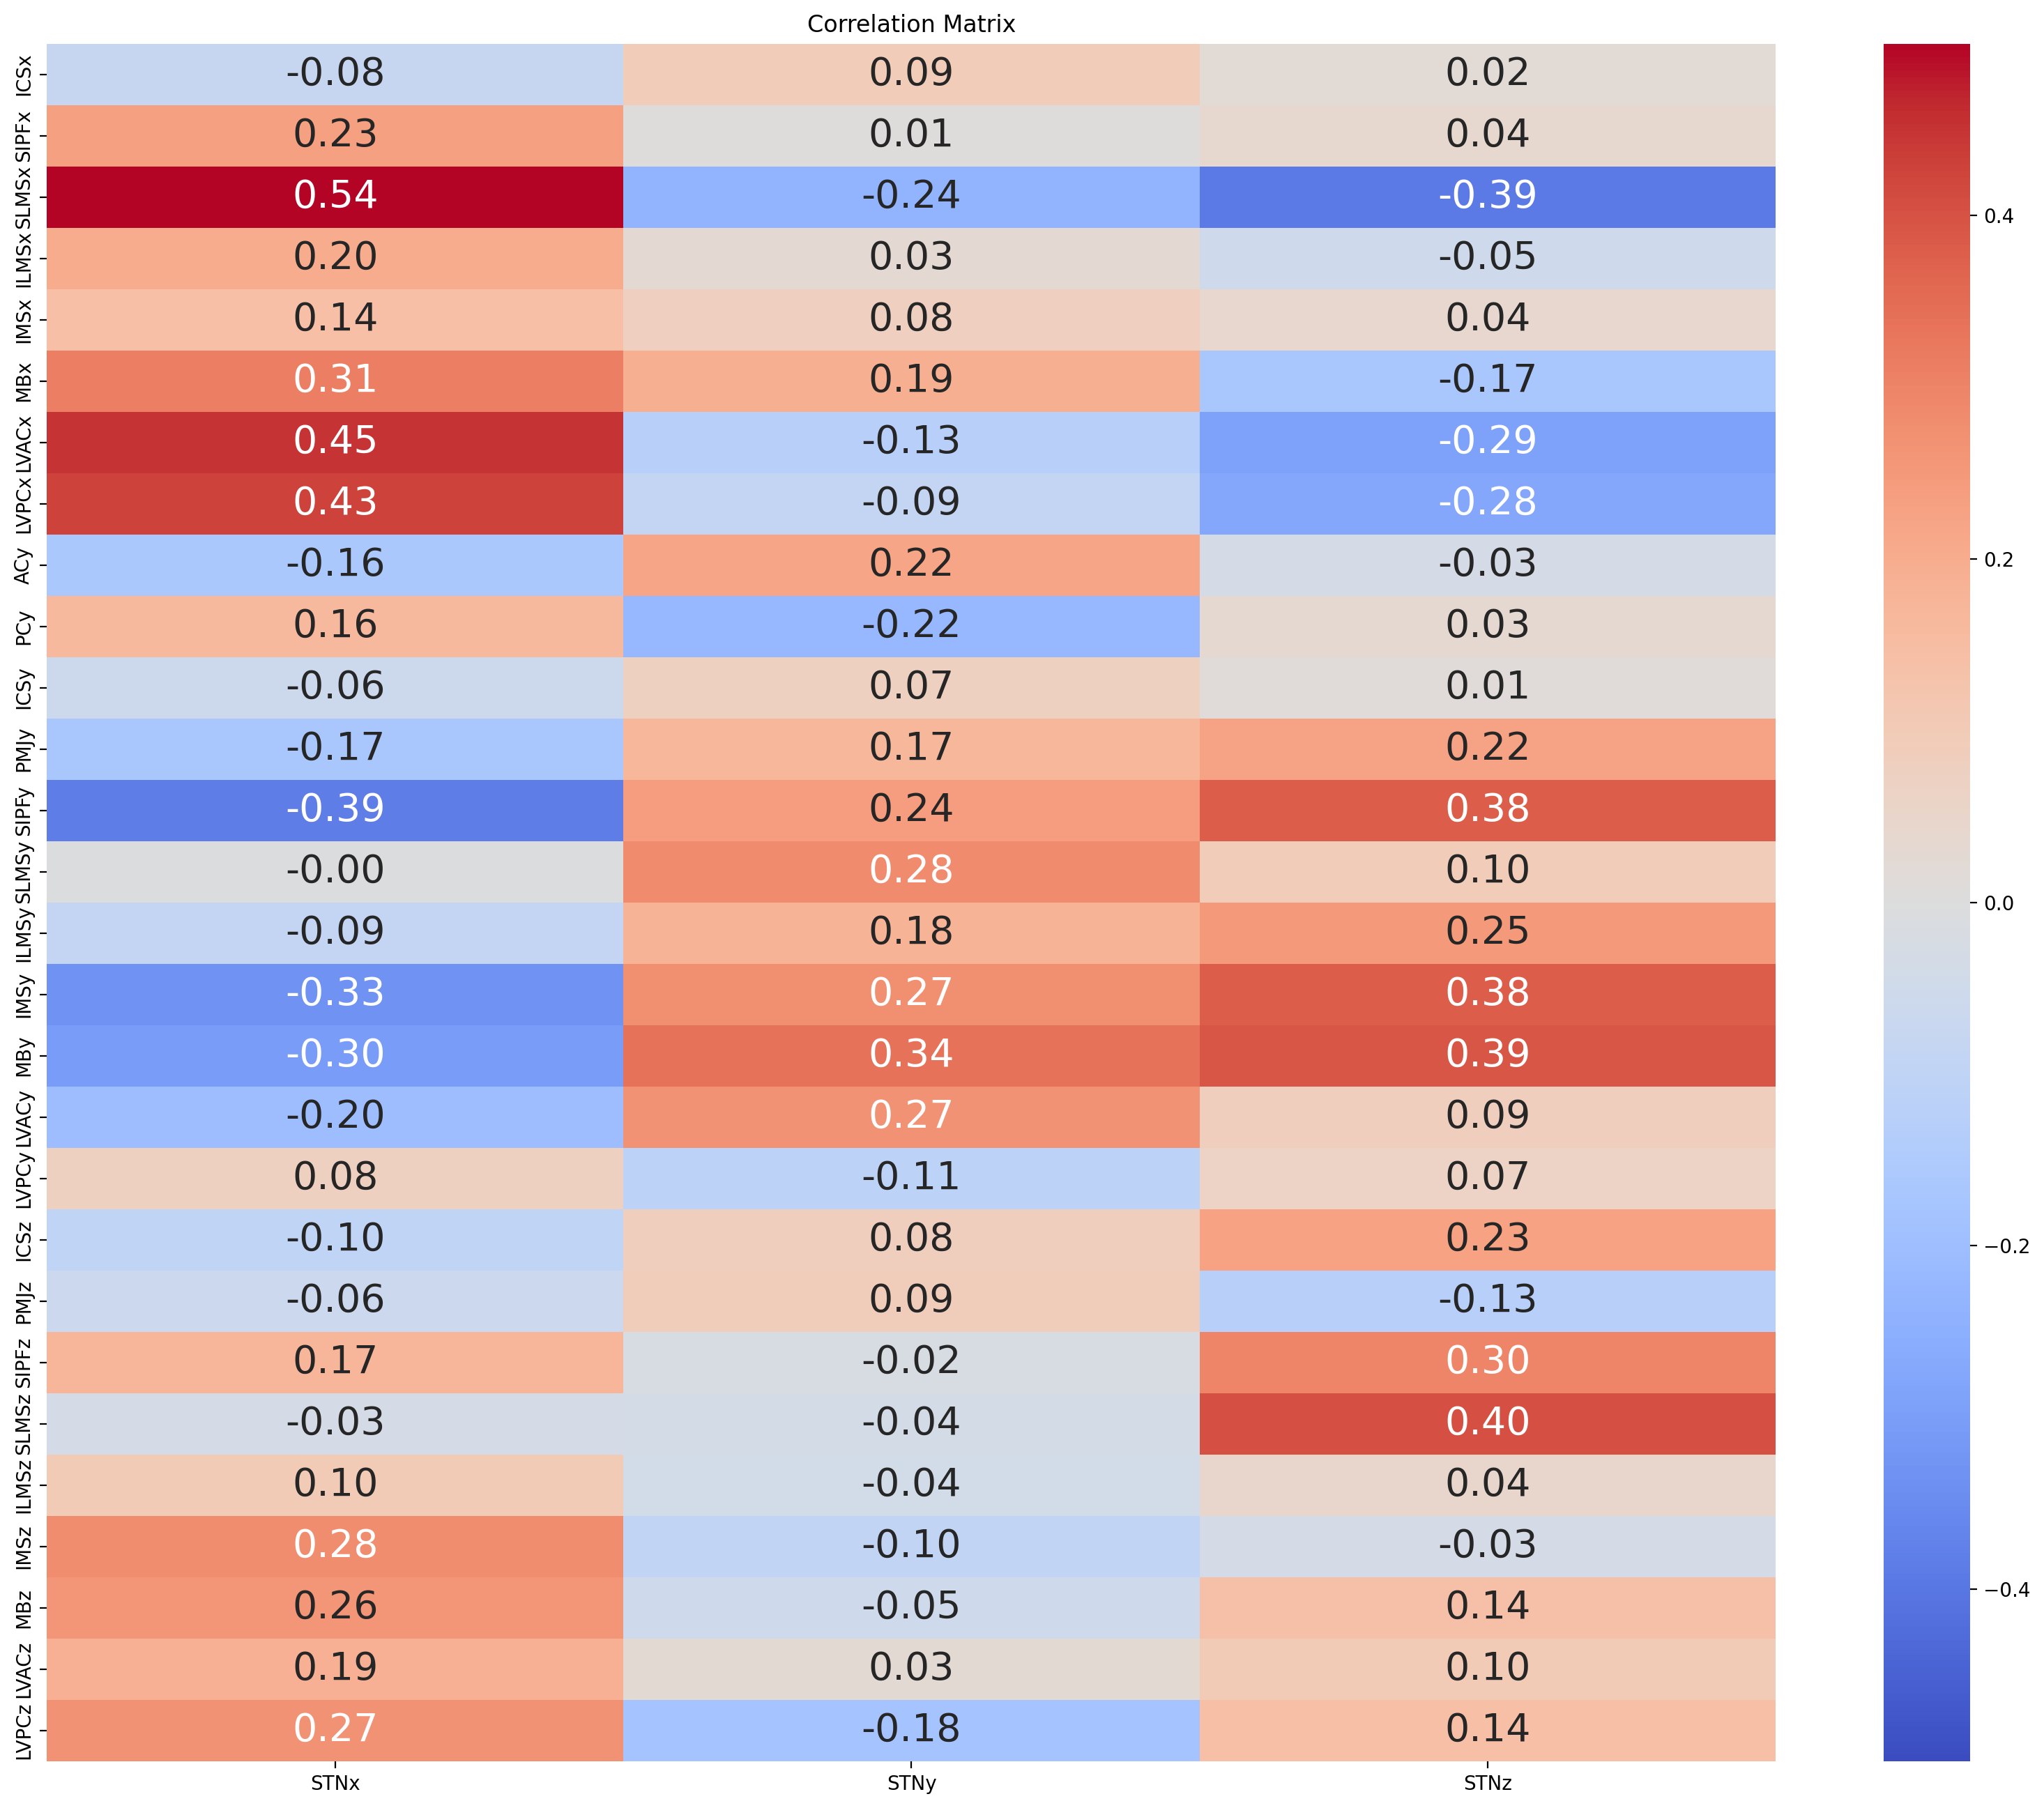

In [41]:
midbrain_features = concatenated_df_2.columns
# Assuming df_afids is the DataFrame containing the features
# Assuming df_targets is the DataFrame containing the target variables

# Create an empty DataFrame to store the correlations
correlation_matrix = pd.DataFrame(index=midbrain_features, columns=STN_target.columns)

# Loop through the columns of df_afids and df_targets
for feature_col in midbrain_features:
    for target_col in STN_target.columns:
        # Get the feature column and target column as numpy arrays
        feature_values = concatenated_df_2[feature_col].values
        target_values = STN_target[target_col].values

        # Calculate the correlation between the feature column and target column
        correlation = np.corrcoef(feature_values, target_values)[0, 1]

        # Store the correlation value in the correlation matrix DataFrame
        correlation_matrix.loc[feature_col, target_col] = correlation

# Print the correlation matrix
print("Correlation with Target Variables:")
print(correlation_matrix)

# Assuming correlation_matrix is the DataFrame containing the correlation values

# Convert correlation matrix values to numeric
correlation_matrix = correlation_matrix.astype(float)
correlation_matrix = correlation_matrix.dropna()

# Compute global min and max for normalization
vmin = np.min(correlation_matrix)
vmax = np.max(correlation_matrix)
norm = TwoSlopeNorm(vmin=-0.65, vcenter=0, vmax=0.65)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, 
            annot=True, 
            vmin= -0.5, 
            vmax=0.5, 
            cmap='coolwarm', 
            fmt=".2f", 
            annot_kws={"size": 20})  # Increase font size here
plt.title("Correlation Matrix")

# Save the figure with a transparent background
plt.savefig('/Users/alaataha/Documents/GitHub/afids-pred/figures/STN_correlation_matrix.png', dpi=300, bbox_inches='tight', transparent=True)